# Data Science 1 Final Assignment

In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

In [2]:
np.random.seed(20240306)

# 1

## A.: How does the regularized estimator (predictor) βˆridge 0 compare with the OLS estimator?

## B.: Beta ridge

In [3]:
# Simplest possible predictive model

# Suppose that β0 = 1 and ϵ ∼ N(0, σ2) with σ2 = 4. Sample size of 20

# Define the "function"
Beta0 = 1

# Sample size
n = 20

# Epsilon aka noise
epsilon = np.random.normal(0, 4, n)




Y = Beta0 + epsilon

# collect results into a DataFrame
result_columns = ["Lambda", "Ridge"]
df = pd.DataFrame(columns=result_columns)

#Init
lambresults = []

#Ridge solution
for lamb in range(20):

    loop = []
    for i in range(n):
        loop.append(Y[i]/(n+lamb+1))

    lambresults.append(sum(loop))


# Organize
df = pd.DataFrame({
    'Lambda': np.arange(1,21,1),
    'Results': lambresults
})

df

,Lambda,Results
0,1,1.521506
1,2,1.452347
2,3,1.389202
3,4,1.331318
4,5,1.278065
5,6,1.228909
6,7,1.183394
7,8,1.141130
8,9,1.101781
9,10,1.065055


## C.: Repeat 1000 times

In [4]:
results = []
#Repeat part b), say, 1000 times
R = 1000

Beta0 = 1
n = 20
for _ in range(R):
    epsilon = np.random.normal(0, 4, n)
    Y = Beta0 + epsilon

    lambresults = []
    for lamb in range(20):

        loop = []
        for i in range(n):
            loop.append(Y[i]/(n+lamb+1))

        lambresults.append(sum(loop))
    
    results.append(lambresults)




# Compute bias2, variance and MSE
results = np.array(results)
bias2 = (np.mean(results, axis=0) - Beta0)**2
variance = np.var(results, axis=0)
mse = np.mean((results - Beta0) ** 2, axis=0)

# Organize results into a table
df = pd.DataFrame({
    'Lambda': np.arange(1,21,1),
    'bias2': bias2.flatten(),
    'variance': variance.flatten(),
    'MSE': mse.flatten()
})
df

,Lambda,bias2,variance,MSE
0,1,0.002850,0.757528,0.760378
1,2,0.009296,0.690227,0.699522
2,3,0.018414,0.631512,0.649926
3,4,0.029485,0.579982,0.609467
4,5,0.041961,0.534512,0.576473
5,6,0.055426,0.494186,0.549612
6,7,0.069561,0.458258,0.527819
7,8,0.084123,0.426109,0.510232
8,9,0.098923,0.397229,0.496152
9,10,0.113819,0.371189,0.485007


## D

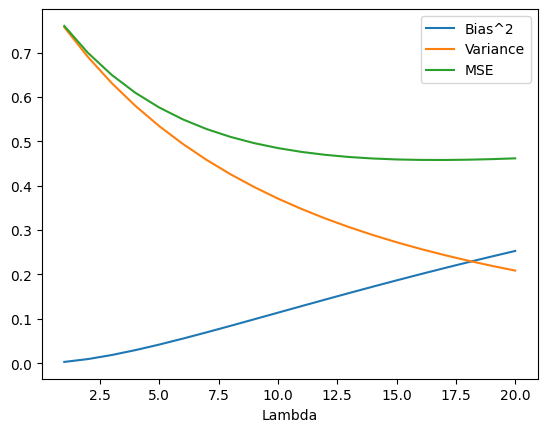

In [5]:
plt.plot(np.arange(1,21,1), bias2, label='Bias^2')
plt.plot(np.arange(1,21,1), variance, label='Variance')
plt.plot(np.arange(1,21,1), mse, label='MSE')
plt.xlabel('Lambda')
plt.legend()
plt.show()

# 2

# 3